In [42]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [43]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [44]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [45]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [46]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [47]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [48]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [49]:
len(df)

25867

In [50]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [51]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [52]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [53]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean()
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

In [54]:
emotion_va

{'anger': (-1.5756457564575646, 3.5912259122591226),
 'anticipation': (0.5624470428740891, 2.463650228774784),
 'disgust': (-0.876, 2.441),
 'fear': (-1.3390254060807996, 3.239067055393586),
 'joy': (1.9020501138952164, 2.9552961275626424),
 'sadness': (-1.5707317073170732, 3.4221388367729833),
 'surprise': (0.47635135135135137, 2.5664414414414414),
 'trust': (1.4142011834319526, 2.5694561848408)}

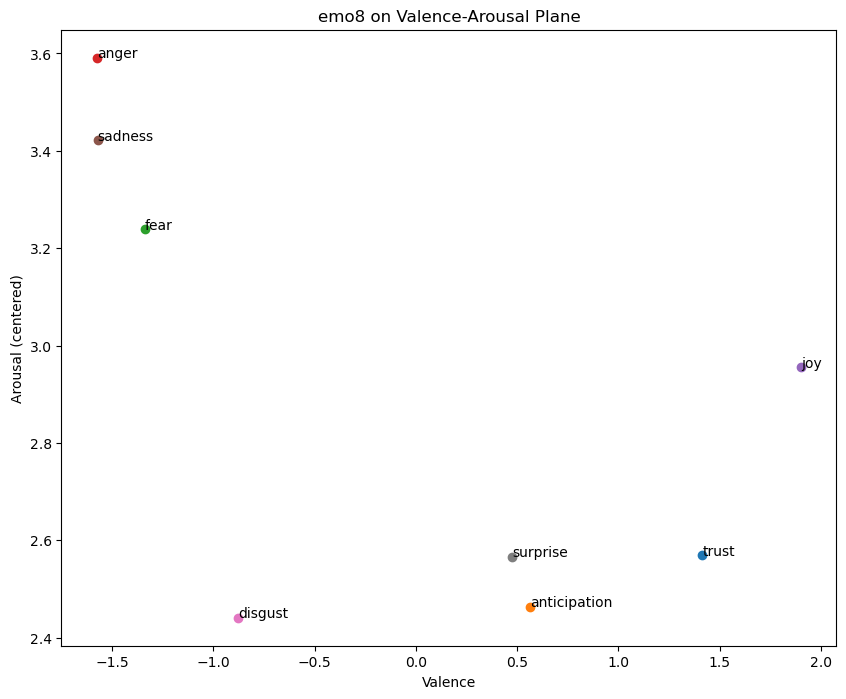

In [55]:
VALENCE_BINS = np.linspace(-3, 3, num=7)
AROUSAL_BINS = np.linspace(0, 6, num=7)

def to_bin(value, bins):
    return int(np.abs(bins - value).argmin())

plt.figure(figsize=(10, 8))
emotion_va_bins = {}

for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    valence_bin = to_bin(avg_valence, VALENCE_BINS)
    arousal_bin = to_bin(avg_arousal, AROUSAL_BINS)
    emotion_va_bins[emo] = (valence_bin, arousal_bin)
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)

plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [56]:
df['valence_bin'] = df['valence'].apply(lambda x: to_bin(x, VALENCE_BINS))
df['arousal_bin'] = df['arousal'].apply(lambda x: to_bin(x, AROUSAL_BINS))

In [57]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,valence_bin,arousal_bin
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0,3,2
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0,3,2
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3,5,2
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4,4,2
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0,3,3


In [58]:
emotion_va_bins

{'trust': (4, 3),
 'anticipation': (4, 2),
 'fear': (2, 3),
 'anger': (1, 4),
 'joy': (5, 3),
 'sadness': (1, 3),
 'disgust': (2, 2),
 'surprise': (3, 3)}

In [59]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [60]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [61]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [62]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [63]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig

emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [64]:
# Delete the last layer so I can use it as a feature extractor
face_model_base = nn.Sequential(*list(face_model_base.children())[:-1])

In [65]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [66]:
scene_model_base = nn.Sequential(*list(scene_model_base.children())[:-1])

In [67]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [68]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [69]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [70]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "scenes_5"), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        tensor = super().__getitem__(f"scene_{i}")
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

# DPL with symbolic knowledge about the data

In [71]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        output = self.module(*args, **kwargs)

        # Flatten output if it has extra dimensions
        if isinstance(output, torch.Tensor) and output.dim() == 3:
            output = output.squeeze(1)  # Remove the middle dimension [B, 1, C] -> [B, C]
        
        return output
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [72]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [73]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert emotion labels to indices
    label_to_idx = {emo: i for i, emo in enumerate(fe_labels)}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

# Initialize the models, network and final DPL model

In [74]:
from deepproblog.utils.standard_networks import MLP
face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)

In [75]:
class FaceValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)
        

In [76]:
face_val_train_dataset = FaceValDataset(train_indices)
face_val_test_dataset = FaceValDataset(test_indices)

face_val_train_loader = DataLoader(face_val_train_dataset, batch_size=1, shuffle=True)
face_val_test_loader = DataLoader(face_val_test_dataset, batch_size=1, shuffle=False)

In [77]:
def custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight=0.3):
    """
    Loss function that rewards predictions within ±1 bin
    
    Args:
        logits: model predictions (B, num_bins)
        y: true labels (B,)
        weight_tensor: class weights for CE loss
        ce_weight: weight for exact match CE loss
        reg_weight: weight for regression loss
        adjacent_weight: weight for adjacent bin reward (default 0.3)
    """
    probs = logits.softmax(dim=1)  # (B, num_bins)
    num_bins = logits.size(1)
    
    # 1. Regression loss (smooth L1)
    bins = torch.arange(num_bins, device=DEVICE).float()
    v_hat = (probs * bins).sum(dim=1)
    reg_loss = F.smooth_l1_loss(v_hat, y.float())
    
    # 2. Exact match CE loss
    ce_loss = F.cross_entropy(logits, y, weight=weight_tensor)
    
    # 3. Adjacent bin reward: create soft targets
    # For each true label, also give credit to ±1 bins
    soft_targets = torch.zeros_like(probs)
    batch_size = y.size(0)
    
    for i in range(batch_size):
        true_bin = y[i].item()
        # Main target gets full weight
        soft_targets[i, true_bin] = 1.0
        
        # Adjacent bins get partial weight
        if true_bin > 0:
            soft_targets[i, true_bin - 1] = adjacent_weight
        if true_bin < num_bins - 1:
            soft_targets[i, true_bin + 1] = adjacent_weight
    
    # Normalize soft targets to sum to 1
    soft_targets = soft_targets / soft_targets.sum(dim=1, keepdim=True)
    
    # KL divergence between predictions and soft targets
    log_probs = F.log_softmax(logits, dim=1)
    adjacent_loss = F.kl_div(log_probs, soft_targets, reduction='batchmean')
    
    # Combine losses
    total_loss = ce_weight * ce_loss + reg_weight * reg_loss + adjacent_weight * adjacent_loss
    
    return total_loss

In [ ]:
def train_epoch(model, loader, optimizer, class_weights=None, ce_weight=0.5, reg_weight=0.5, adjacent_weight=0.3):
    model.train()
    total_loss = 0
    total_correct = 0
    total_correct_adjacent = 0  # Track ±1 accuracy during training
    total_samples = 0

    # Convert class_weights (numpy or list) into tensor just once
    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, device=DEVICE).float()
    else:
        weight_tensor = None  # CE will treat classes equally

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).long()  # CE requires long dtype

        optimizer.zero_grad()

        # Forward pass
        logits = model(x)                    # (B, num_bins)
        loss = custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight)
        loss.backward()
        optimizer.step()

        # ---- Metrics ----
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_correct_adjacent += ((preds - y).abs() <= 1).sum().item()  # Count ±1 predictions
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    accuracy_adjacent = total_correct_adjacent / total_samples  # Calculate ±1 accuracy

    return avg_loss, accuracy, accuracy_adjacent

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_with_metrics(model, loader, labels, allow_adjacent=True, class_weights=None, ce_weight=0.5, reg_weight=0.5, adjacent_weight=0.3):
    """Enhanced evaluate function that returns metrics"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_correct_adjacent = 0  # Count predictions within 1 bin
    total_samples = 0

    all_labels = []
    all_preds = []

    # Convert class_weights (numpy or list) into tensor just once
    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, device=DEVICE).float()
    else:
        weight_tensor = None  # CE will treat classes equally

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            logits = model(x)
            loss = custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Exact matches
            total_correct += (preds == y).sum().item()
            
            # Adjacent matches (within 1 bin)
            if allow_adjacent:
                adjacent_correct = ((preds - y).abs() <= 1).sum().item()
                total_correct_adjacent += adjacent_correct
            
            total_samples += x.size(0)

    # Calculate metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(labels)), zero_division=0
    )
    
    # Overall metrics
    accuracy = total_correct / total_samples
    accuracy_adjacent = total_correct_adjacent / total_samples if allow_adjacent else None
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'accuracy_adjacent': accuracy_adjacent,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_detailed_metrics(results, label_names):
    """Print detailed metrics in a nice format"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Loss:                {results['loss']:.4f}")
    print(f"Accuracy (Exact):    {results['accuracy']:.4f}")
    if results.get('accuracy_adjacent') is not None:
        print(f"Accuracy (±1 bin):   {results['accuracy_adjacent']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Label':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")


def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
valence_bin_labels = [f"V{i}" for i in range(len(VALENCE_BINS))]
arousal_bin_labels = [f"A{i}" for i in range(len(AROUSAL_BINS))]

In [ ]:
class_counts = np.bincount(df['valence_bin'].values)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()

In [82]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    face_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc, train_acc_adj = train_epoch(
        face_val_model, 
        face_val_train_loader, 
        optimizer, 
        class_weights=class_weights, 
        ce_weight=0.3, 
        reg_weight=0.5,
        adjacent_weight=0.2
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            face_val_model, 
            face_val_test_loader, 
            valence_bin_labels, 
            class_weights=class_weights, 
            ce_weight=0.3, 
            reg_weight=0.5,
            adjacent_weight=0.2
            )
        print_detailed_metrics(results, valence_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)

# torch.save(face_val_model.state_dict(), os.path.join(model_dir, "face_val_model.pth"))
# Load the trained baseline model weights

face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)


face_val_model.load_state_dict(torch.load(os.path.join(model_dir, "face_val_model.pth")))


Epoch 1/20


KeyboardInterrupt: 

In [ ]:
face_val_network = Network(face_val_model, "face_val_model", batching=True)

face_val_network.optimizer = optimizer

In [ ]:
# face_aro_model_raw = MLP(
#     768,        # input size
#     256, 64,   # hidden layers
#     len(AROUSAL_BINS),       # output size (arousal bins)   
#     activation=nn.ReLU,
#     softmax=False,   
#     batch=True
# )
# face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)


In [ ]:
# class FaceAroDataset(TorchDataset):
#     def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
#         self.indices = indices
#         self.feature_dir = feature_dir

#     def __getitem__(self, idx):
#         if isinstance(idx, (tuple, list)):
#             idx = idx[0]
#         if isinstance(idx, Constant):
#             idx = int(idx.value)

#         idx = self.indices[idx]    
#         arousal_bin = df.loc[idx]['arousal_bin']
#         face_feature_list = []
#         for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
#             face_rank = int(box_row['face_rank'])
#             feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
#             face_feature = torch.load(feature_path)
#             face_feature_list.append(face_feature)

#         if len(face_feature_list) == 0:
#             face_avg = torch.zeros(768)

#         else:
#             face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

#         face_avg = face_avg.squeeze()

#         return face_avg.to(DEVICE), arousal_bin
    
#     def __len__(self):
#         return len(self.indices)

In [ ]:
# face_aro_train_dataset = FaceAroDataset(train_indices)
# face_aro_test_dataset = FaceAroDataset(test_indices)

# face_aro_train_loader = DataLoader(face_aro_train_dataset, batch_size=batch_size, shuffle=True)
# face_aro_test_loader = DataLoader(face_aro_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# class_counts = np.bincount(df['arousal_bin'].values)
# class_weights = 1.0 / (class_counts + 1e-6)
# class_weights /= class_weights.sum()

In [ ]:
# EPOCHS = 20

# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
#     # Train
#     train_loss, train_acc, train_acc_adj = train_epoch(
#         face_aro_model, 
#         face_aro_train_loader, 
#         optimizer, 
#         class_weights=class_weights, 
#         ce_weight=0.3, 
#         reg_weight=0.5,
#         adjacent_weight=0.2
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
#     if (epoch + 1) % 5 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             face_aro_model, 
#             face_aro_test_loader, 
#             arousal_bin_labels, 
#             class_weights=class_weights, 
#             ce_weight=0.3, 
#             reg_weight=0.5,
#             adjacent_weight=0.2
#         )
#         print_detailed_metrics(results, arousal_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)

# torch.save(face_aro_model.state_dict(), os.path.join(model_dir, "face_aro_model.pth"))
# Load the trained baseline model weights

face_aro_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)

face_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "face_aro_model.pth")))

<All keys matched successfully>

In [ ]:
face_aro_network = Network(face_aro_model, "face_aro_model", batching=True)

optimizer = torch.optim.AdamW(
    face_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

face_aro_network.optimizer = optimizer

In [ ]:
# scene_val_model_raw = MLP(
#     512,        # input size
#     256, 64,   # hidden layers
#     len(VALENCE_BINS),       # output size (valence bins)   
#     activation=nn.ReLU,
#     softmax=False,   
#     batch=True
# )
# scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)

In [ ]:
# class SceneValDataset(TorchDataset):
#     def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
#         self.indices = indices
#         self.feature_dir = feature_dir

#     def __getitem__(self, idx):
#         if isinstance(idx, (tuple, list)):
#             idx = idx[0]
#         if isinstance(idx, Constant):
#             idx = int(idx.value)

#         idx = self.indices[idx]    
#         valence_bin = df.loc[idx]['valence_bin']
#         feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
#         scene_feature = torch.load(feature_path)
#         scene_feature = scene_feature.squeeze()

#         return scene_feature.to(DEVICE), valence_bin
    
#     def __len__(self):
#         return len(self.indices)

In [ ]:
# scene_val_train_dataset = SceneValDataset(train_indices)
# scene_val_test_dataset = SceneValDataset(test_indices)

# scene_val_train_loader = DataLoader(scene_val_train_dataset, batch_size=batch_size, shuffle=True)
# scene_val_test_loader = DataLoader(scene_val_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# class_counts = np.bincount(df['valence_bin'].values)
# class_weights = 1.0 / (class_counts + 1e-6)
# class_weights /= class_weights.sum()

In [ ]:
# EPOCHS = 20

# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
#     # Train
#     train_loss, train_acc, train_acc_adj = train_epoch(
#         scene_val_model, 
#         scene_val_train_loader, 
#         optimizer, 
#         class_weights=class_weights, 
#         ce_weight=0.3, 
#         reg_weight=0.5,
#         adjacent_weight=0.2
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
#     if (epoch + 1) % 5 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             scene_val_model, 
#             scene_val_test_loader, 
#             valence_bin_labels, 
#             class_weights=class_weights, 
#             ce_weight=0.3, 
#             reg_weight=0.5,
#             adjacent_weight=0.2
#             )
#         print_detailed_metrics(results, valence_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)

# torch.save(scene_val_model.state_dict(), os.path.join(model_dir, "scene_val_model.pth"))
# Load the trained baseline model weights

scene_val_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)
    activation=nn.ReLU,
    softmax=True,
    batch=True
)
scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)
scene_val_model.load_state_dict(torch.load(os.path.join(model_dir, "scene_val_model.pth")))

<All keys matched successfully>

In [ ]:
scene_val_network = Network(scene_val_model, "scene_val_model", batching=True)

optimizer = torch.optim.AdamW(
    scene_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

scene_val_network.optimizer = optimizer

In [ ]:
# scene_aro_model_raw = MLP(
#     512,        # input size
#     256, 64,   # hidden layers
#     len(AROUSAL_BINS),       # output size (arousal bins)   
#     activation=nn.ReLU,
#     softmax=False,   
#     batch=True
# )
# scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)

In [ ]:
# class SceneAroDataset(TorchDataset):
#     def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
#         self.indices = indices
#         self.feature_dir = feature_dir

#     def __getitem__(self, idx):
#         if isinstance(idx, (tuple, list)):
#             idx = idx[0]
#         if isinstance(idx, Constant):
#             idx = int(idx.value)

#         idx = self.indices[idx]    
#         arousal_bin = df.loc[idx]['arousal_bin']
#         feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
#         scene_feature = torch.load(feature_path)
#         scene_feature = scene_feature.squeeze()

#         return scene_feature.to(DEVICE), arousal_bin
    
#     def __len__(self):
#         return len(self.indices)

In [ ]:
# scene_aro_train_dataset = SceneAroDataset(train_indices)
# scene_aro_test_dataset = SceneAroDataset(test_indices)

# scene_aro_train_loader = DataLoader(scene_aro_train_dataset, batch_size=batch_size, shuffle=True)
# scene_aro_test_loader = DataLoader(scene_aro_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# class_counts = np.bincount(df['arousal_bin'].values)
# class_weights = 1.0 / (class_counts + 1e-6)
# class_weights /= class_weights.sum()

In [ ]:
# EPOCHS = 20

# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
#     # Train
#     train_loss, train_acc, train_acc_adj = train_epoch(
#         scene_aro_model, 
#         scene_aro_train_loader, 
#         optimizer, 
#         class_weights=class_weights, 
#         ce_weight=0.3, 
#         reg_weight=0.5,
#         adjacent_weight=0.2
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
#     if (epoch + 1) % 5 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             scene_aro_model, 
#             scene_aro_test_loader, 
#             arousal_bin_labels, 
#             class_weights=class_weights, 
#             ce_weight=0.3, 
#             reg_weight=0.5,
#             adjacent_weight=0.2
#         )
#         print_detailed_metrics(results, arousal_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)

# torch.save(scene_aro_model.state_dict(), os.path.join(model_dir, "scene_aro_model.pth"))
# Load the trained baseline model weights

scene_aro_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)
scene_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "scene_aro_model.pth")))

<All keys matched successfully>

In [ ]:
scene_aro_network = Network(scene_aro_model, "scene_aro_model", batching=True)

optimizer = torch.optim.AdamW(
    scene_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

scene_aro_network.optimizer = optimizer

In [ ]:
class FaceFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load all face backbone features (768 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # 
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(768, dtype=torch.float32)
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (768,)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_features_train = FaceFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
face_features_test = FaceFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))        

In [ ]:
class SceneFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (512,)

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_features_train = SceneFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
scene_features_test = SceneFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))

In [ ]:
emotion_centroids = {}
# For every emotion, count +3 for the valence value
for emo, (valence, arousal) in emotion_va.items():
    valence_centered = valence + 3
    emotion_centroids[emo] = (valence_centered, arousal)

In [ ]:
emotion_centroids

{'anger': (1.4243542435424354, 3.5912259122591226),
 'anticipation': (3.562447042874089, 2.463650228774784),
 'disgust': (2.124, 2.441),
 'fear': (1.6609745939192004, 3.239067055393586),
 'joy': (4.902050113895216, 2.9552961275626424),
 'sadness': (1.4292682926829268, 3.4221388367729833),
 'surprise': (3.4763513513513513, 2.5664414414414414),
 'trust': (4.414201183431953, 2.5694561848408)}

In [ ]:
class VA2Emotion(nn.Module):
    def __init__(self, centroids):
        super().__init__()
        self.centroids = nn.Parameter(torch.tensor(centroids, dtype=torch.float32), requires_grad=False)
        self.log_alpha = nn.Parameter(torch.tensor(0.0))  # learnable temperature

    def forward(self, valence, arousal):
        # Convert inputs to tensors if they're lists/scalars
        if not isinstance(valence, torch.Tensor):
            valence = torch.tensor(valence, dtype=torch.float32)
        if not isinstance(arousal, torch.Tensor):
            arousal = torch.tensor(arousal, dtype=torch.float32)
        
        # Move to correct device
        device = self.centroids.device
        valence = valence.to(device)
        arousal = arousal.to(device)
        
        # Ensure they are at least 1D
        if valence.dim() == 0:
            valence = valence.unsqueeze(0)
        if arousal.dim() == 0:
            arousal = arousal.unsqueeze(0)
            
        # Ensure they are 2D for broadcasting
        if valence.dim() == 1:
            valence = valence.unsqueeze(1)  # (batch, 1)
        if arousal.dim() == 1:
            arousal = arousal.unsqueeze(1)  # (batch, 1)
        
        V = valence  # (batch, 1)
        A = arousal  # (batch, 1)

        C = self.centroids  # shape (8, 2)
        # compute squared distances -> shape (batch, 8)
        d2 = (V - C[:, 0])**2 + (A - C[:, 1])**2
        
        # softmax over negative distances
        alpha = torch.exp(self.log_alpha)
        probs = F.softmax(-alpha * d2, dim=1)
        return probs

# Recreate the model with the fixed class
va2emotion_model_raw = VA2Emotion([list(emotion_centroids.values())])
va2emotion_model = DeviceAwareModule(va2emotion_model_raw).to(DEVICE)

va2emotion_network = Network(va2emotion_model, "va2emotion_model", batching=True)
va2emotion_network.optimizer = torch.optim.AdamW(
    va2emotion_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [ ]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model_6.pl"), [face_val_network, face_aro_network, scene_val_network, scene_aro_network, va2emotion_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 10, heuristic2))

# model.register_foreign(closest_emotion, "closest_emotion", 2, 1)

model.add_tensor_source("face_features_train", face_features_train)
model.add_tensor_source("scene_features_train", scene_features_train)
model.add_tensor_source("face_features_test", face_features_test)
model.add_tensor_source("scene_features_test", scene_features_test)

In [ ]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_features_{self.dataset_name}", Constant(idx))),
                Term("tensor", Term(f"scene_features_{self.dataset_name}", Constant(idx))),
                Term(label_str)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices, "train")
test_dataset = FEQUeryDataset(test_indices, "test")

In [ ]:
train_dataset.to_query(0)

(1.0::final_emotion(tensor(face_features_train(2405)),tensor(scene_features_train(2405)),joy), {})

In [ ]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

In [ ]:
test_input = torch.load(os.path.join(data_dir, "pretrained_backbone", "faces", "face_0_0.pt")).to(DEVICE)
test_output = face_val_model(test_input.unsqueeze(0))
print(test_output)
test_output.shape

tensor([[5.3549e-04, 1.3191e-03, 2.4600e-03, 9.7618e-03, 9.2532e-02, 3.3119e-01,
         5.6220e-01]], device='cuda:0', grad_fn=<SqueezeBackward1>)


torch.Size([1, 7])

'trust'

In [ ]:
test_idx = np.random.choice(test_indices)

debug_query(model,
            "test_face_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_face_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_scene_val_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_scene_aro_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_combine_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CV"))

debug_query(model,
            "test_combine_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CA"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("Emotion"))

print("Debugging queries done.")


Testing: test_face_val_bin
  test_face_val_bin(tensor(face_features_test(16865)),0): 0.3916
  test_face_val_bin(tensor(face_features_test(16865)),1): 0.2479
  test_face_val_bin(tensor(face_features_test(16865)),2): 0.1276
  test_face_val_bin(tensor(face_features_test(16865)),3): 0.1217
  test_face_val_bin(tensor(face_features_test(16865)),4): 0.0669
  test_face_val_bin(tensor(face_features_test(16865)),5): 0.0324
  test_face_val_bin(tensor(face_features_test(16865)),6): 0.0120

Testing: test_face_aro_bin
  test_face_aro_bin(tensor(face_features_test(16865)),3): 0.1622
  test_face_aro_bin(tensor(face_features_test(16865)),0): 0.1553
  test_face_aro_bin(tensor(face_features_test(16865)),1): 0.1543
  test_face_aro_bin(tensor(face_features_test(16865)),2): 0.1436
  test_face_aro_bin(tensor(face_features_test(16865)),4): 0.1348
  test_face_aro_bin(tensor(face_features_test(16865)),6): 0.1259
  test_face_aro_bin(tensor(face_features_test(16865)),5): 0.1239

Testing: test_scene_val_bin
  tes

In [ ]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:12.9760 	Average Loss:  1.9086233973503113
Iteration:  4 	s:26.2368 	Average Loss:  3.9864546060562134
Iteration:  6 	s:24.7883 	Average Loss:  3.528475135564804
Iteration:  8 	s:26.5274 	Average Loss:  3.418980821967125
Iteration:  10 	s:24.2322 	Average Loss:  3.172773204743862
Iteration:  12 	s:25.8730 	Average Loss:  3.1551909148693085
Iteration:  14 	s:24.9267 	Average Loss:  3.007840506732464
Iteration:  16 	s:25.3294 	Average Loss:  2.5445772036910057
Iteration:  18 	s:24.9283 	Average Loss:  2.4298143088817596
Iteration:  20 	s:27.1610 	Average Loss:  2.7054994106292725
Iteration:  22 	s:26.8331 	Average Loss:  2.2227362357079983
Iteration:  24 	s:23.5747 	Average Loss:  2.097135655581951
Iteration:  26 	s:25.1679 	Average Loss:  2.158589370548725
Iteration:  28 	s:26.3303 	Average Loss:  1.7333231717348099
Iteration:  30 	s:25.3958 	Average Loss:  2.040354438126087
Iteration:  32 	s:24.6838 	Average Loss:  1.7163233943283558
It

Exception ignored on calling ctypes callback function: <function _foreignWrapper.<locals>.wrapper at 0x00000223D74EF9A0>
Traceback (most recent call last):
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\pyswip\easy.py", line 528, in wrapper
    r = fun(*args)
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\engines\approximate_engine.py", line 154, in func
    probabilities = net([term2list(inputs, False)])
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 126, in __call__
    for inputs in zip(*inputs):
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 124, in <genexpr>
    inputs = (self.function(*e) for e in to_evaluate)
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 11, in tensor_function
    return tuple(network.model.get_tensor(arg) for arg in args)
  File "c:\Users\jarne\miniconda3\envs\dpl_ba

PrologError: Caused by: 'prove(final_emotion(tensor(face_features_train(15850)),tensor(scene_features_train(15850)),joy),10,Proofs,geometric_mean,false)'. Returned: 'error(domain_error(foreign_return_value, 12), context(/(face_val_model_extern, 2), _938))'.

In [ ]:
results = evaluate_dpl_with_metrics(model, test_dataset)
print_dpl_detailed_metrics(results, fe_labels)

Accuracy:  0.2284499420177812

Overall Metrics:
Accuracy: 0.2284

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.0714       0.0020       0.0038       511       
anticipation    0.2289       0.9983       0.3724       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0375       0.1250       0.0470       5174      
Weighted Avg    0.0594       0.2284       0.0855       5174      


In [ ]:
def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

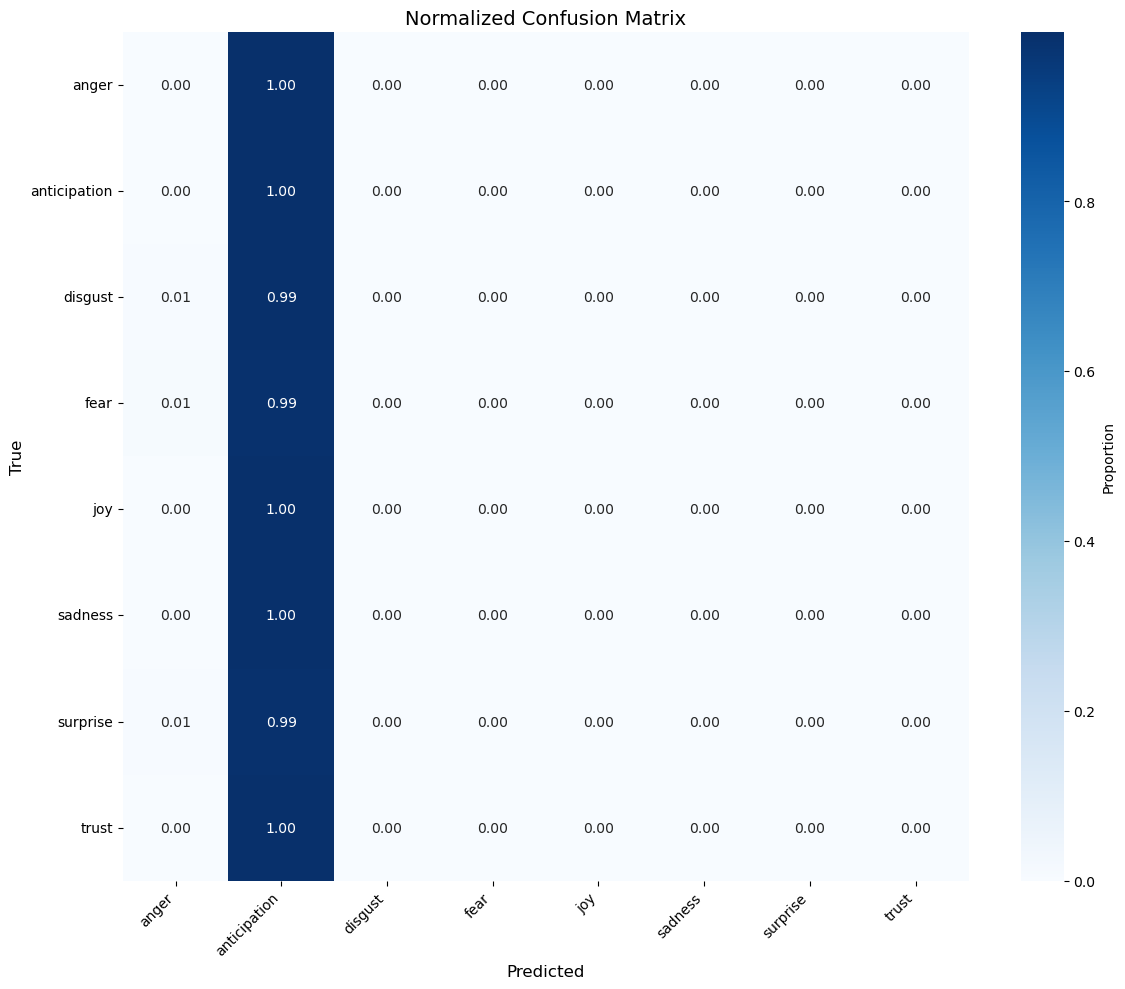

In [ ]:
plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)